In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageEnhance
import cv2
!pip install PyWavelets
import pywt
from scipy.ndimage import median_filter
import timm
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 28.8 MB/s eta 0:00:00


In [2]:
# Set random seed for reproducibility
seed = 42  # You can choose any seed number you want

# Set seed for numpy
np.random.seed(seed)

# Set seed for PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using multi-GPU

In [3]:
!pip install kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rakibhasan3948","key":"a13bd360abac3173cec4ae050d3e348e"}'}

In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [6]:
!kaggle datasets download -d andrewmvd/leukemia-classification

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/leukemia-classification
License(s): other


In [7]:
!unzip leukemia-classification.zip -d /content/leukemia_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/leukemia_data/C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_5_all.bmp  
  inflating: /content/leukemia_data/C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_6_all.bmp  
  inflating: /content/leukemia_data/C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_7_all.bmp  
  inflating: /content/leukemia_data/C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_1_all.bmp  
  inflating: /content/leukemia_data/C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_2_all.bmp  
  inflating: /content/leukemia_data/C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_3_all.bmp  
  inflating: /content/leukemia_data/C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_1_all.bmp  
  inflating: /content/leukemia_data/C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_2_all.bmp  
  inflating: /content/leukemia_data/C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_3_all.bmp  
  inflating: /content/leukemia_data/C-NMC_Leukemia/training_data/fo

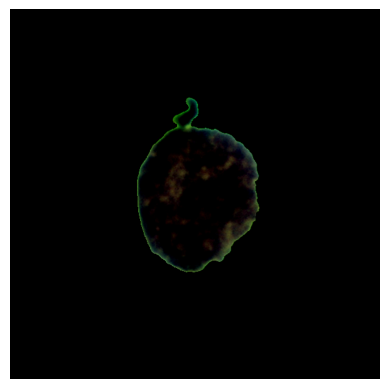

In [8]:
def remap_colors(img_path, target_mean=128, stretch=True):
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)  # Convert to RGB

    # Mask non-black pixels
    mask = np.any(img > 10, axis=-1)  # Ignore near-black pixels
    valid_pixels = img[mask]

    # Compute mean color (centroid)
    mean_color = valid_pixels.mean(axis=0)

    # Shift colors so the mean is at target_mean or stretch it to 0-255
    adjusted_img = img.copy()
    for i in range(3):  # For R, G, B channels
        if stretch:
            min_val, max_val = valid_pixels[:, i].min(), valid_pixels[:, i].max()
            adjusted_img[:, :, i] = (img[:, :, i] - mean_color[i]) / (max_val - min_val) * 255
        else:
            adjusted_img[:, :, i] = img[:, :, i] - mean_color[i] + target_mean

    # Clip to valid RGB range
    adjusted_img = np.clip(adjusted_img, 0, 255).astype(np.uint8)

    return adjusted_img

# Example usage
img_path = "/content/leukemia_data/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/1.bmp"
remapped_img = remap_colors(img_path, target_mean=128, stretch=True)

# Show result
plt.imshow(remapped_img)
plt.axis("off")
plt.show()

In [9]:
class LeukemiaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load image paths and labels
        for fold in ['fold_0', 'fold_1', 'fold_2']:
            for label, category in enumerate(['all', 'hem']):
                folder_path = os.path.join(root_dir, fold, category)
                for img_name in os.listdir(folder_path):
                    self.image_paths.append(os.path.join(folder_path, img_name))
                    self.labels.append(label)  # 0 for 'all', 1 for 'hem'

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image as it is (no preprocessing)
        image = Image.open(image_path).convert('RGB')

        # Apply augmentations
        if self.transform:
            image = self.transform(image)

        return image, label


class RemapColors:
    def __init__(self, target_mean=128, stretch=True):
        self.target_mean = target_mean
        self.stretch = stretch

    def __call__(self, img):
        # Convert PIL image to NumPy
        img = np.array(img).astype(np.float32)

        # Mask non-black pixels
        mask = np.any(img > 10, axis=-1)  # Ignore near-black pixels
        valid_pixels = img[mask]

        # Compute mean color
        mean_color = valid_pixels.mean(axis=0)

        # Shift or stretch colors
        adjusted_img = img.copy()
        for i in range(3):  # R, G, B channels
            if self.stretch:
                min_val, max_val = valid_pixels[:, i].min(), valid_pixels[:, i].max()
                adjusted_img[:, :, i] = (img[:, :, i] - mean_color[i]) / (max_val - min_val) * 255
            else:
                adjusted_img[:, :, i] = img[:, :, i] - mean_color[i] + self.target_mean

        # Clip to valid range and convert back to PIL
        adjusted_img = np.clip(adjusted_img, 0, 255).astype(np.uint8)
        return Image.fromarray(adjusted_img)

# Define augmentation transformations
transform = transforms.Compose([
    RemapColors(target_mean=128, stretch=True),  # Apply color remapping
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.RandomRotation(180),  # Random rotation
    transforms.RandomHorizontalFlip(),  # Horizontal flipping
    transforms.ColorJitter(contrast=0.5),  # Contrast adjustment
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])



# Load dataset with augmentation only
dataset = LeukemiaDataset(root_dir="/content/leukemia_data/C-NMC_Leukemia/training_data", transform=transform)
dataloader = DataLoader(dataset, batch_size=40, shuffle=True)

# Check batch shape
images, labels = next(iter(dataloader))
print(images.shape, labels.shape)  # Expected: (40, 3, 224, 224), (40,)

torch.Size([40, 3, 224, 224]) torch.Size([40])


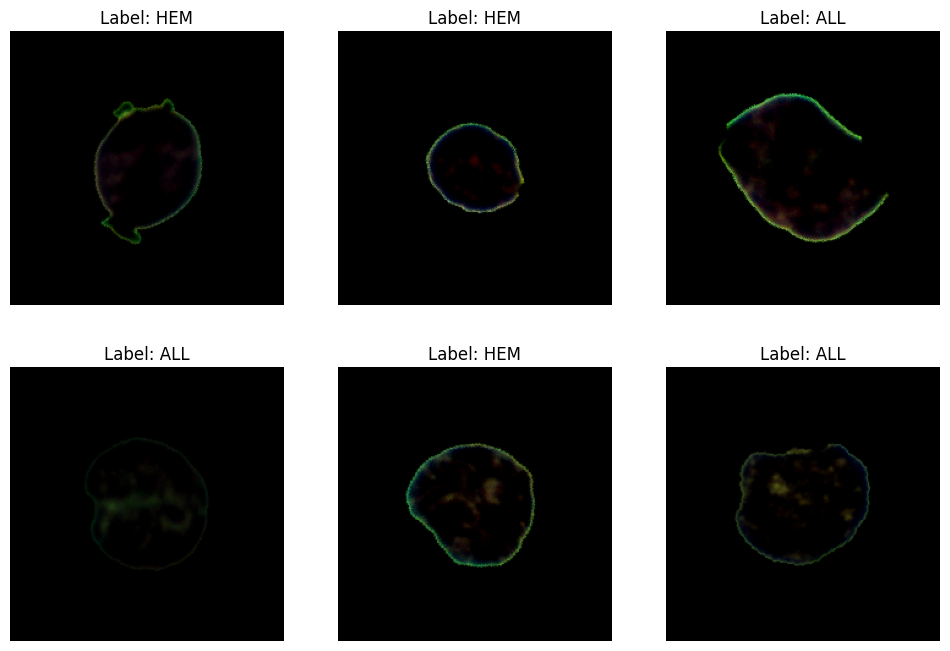

In [10]:
# Get a batch of images
images, labels = next(iter(dataloader))

# Convert images to numpy for visualization
def imshow(img, title):
    img = img.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    img = img * 0.5 + 0.5  # Denormalize (mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Display 6 images
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    imshow(images[i], f"Label: {'ALL' if labels[i] == 0 else 'HEM'}")

plt.show()

In [11]:
class LeukemiaClassifier(nn.Module):
    def __init__(self):
        super(LeukemiaClassifier, self).__init__()
        self.base_model = timm.create_model('resnetrs50', pretrained=True)  # Load pretrained ResNetRS50

        # Modify classifier
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2),  # Output layer (2 classes: all, hem)
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.base_model(x)

# Initialize model
model = LeukemiaClassifier().cuda()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/143M [00:00<?, ?B/s]

In [12]:
# Loss function (CrossEntropy for binary classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adamax)
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)

# Learning rate scheduler (reduce LR by 0.5 after 2 stagnant epochs)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/40


100%|██████████| 80/80 [01:05<00:00,  1.23it/s]


Train Loss: 0.4949, Train Acc: 0.8085
Val Loss: 0.4817, Val Acc: 0.8243

Epoch 2/40


100%|██████████| 80/80 [01:11<00:00,  1.12it/s]


Train Loss: 0.4585, Train Acc: 0.8500
Val Loss: 0.4660, Val Acc: 0.8428

Epoch 3/40


100%|██████████| 80/80 [00:55<00:00,  1.44it/s]


Train Loss: 0.4514, Train Acc: 0.8574
Val Loss: 0.4412, Val Acc: 0.8650

Epoch 4/40


100%|██████████| 80/80 [01:05<00:00,  1.22it/s]


Train Loss: 0.4415, Train Acc: 0.8685
Val Loss: 0.4480, Val Acc: 0.8621

Epoch 5/40


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


Train Loss: 0.4416, Train Acc: 0.8687
Val Loss: 0.4230, Val Acc: 0.8865

Epoch 6/40


100%|██████████| 80/80 [01:05<00:00,  1.22it/s]


Train Loss: 0.4308, Train Acc: 0.8801
Val Loss: 0.4240, Val Acc: 0.8818

Epoch 7/40


100%|██████████| 80/80 [00:55<00:00,  1.43it/s]


Train Loss: 0.4286, Train Acc: 0.8795
Val Loss: 0.4163, Val Acc: 0.8925

Epoch 8/40


100%|██████████| 80/80 [00:58<00:00,  1.36it/s]


Train Loss: 0.4229, Train Acc: 0.8874
Val Loss: 0.4184, Val Acc: 0.8912

Epoch 9/40


100%|██████████| 80/80 [00:55<00:00,  1.44it/s]


Train Loss: 0.4179, Train Acc: 0.8925
Val Loss: 0.4168, Val Acc: 0.8903

Epoch 10/40


100%|██████████| 80/80 [00:55<00:00,  1.45it/s]


Train Loss: 0.4169, Train Acc: 0.8931
Val Loss: 0.4137, Val Acc: 0.8956

Epoch 11/40


100%|██████████| 80/80 [00:54<00:00,  1.46it/s]


Train Loss: 0.4187, Train Acc: 0.8908
Val Loss: 0.4125, Val Acc: 0.8972

Epoch 12/40


100%|██████████| 80/80 [00:54<00:00,  1.46it/s]


Train Loss: 0.4122, Train Acc: 0.8980
Val Loss: 0.4261, Val Acc: 0.8831

Epoch 13/40


100%|██████████| 80/80 [00:55<00:00,  1.43it/s]


Train Loss: 0.4092, Train Acc: 0.9007
Val Loss: 0.4233, Val Acc: 0.8850

Epoch 14/40


100%|██████████| 80/80 [00:55<00:00,  1.45it/s]


Train Loss: 0.4072, Train Acc: 0.9039
Val Loss: 0.4175, Val Acc: 0.8915

Epoch 15/40


100%|██████████| 80/80 [00:55<00:00,  1.44it/s]


Train Loss: 0.3987, Train Acc: 0.9113
Val Loss: 0.3931, Val Acc: 0.9150

Epoch 16/40


100%|██████████| 80/80 [00:54<00:00,  1.46it/s]


Train Loss: 0.3918, Train Acc: 0.9193
Val Loss: 0.3972, Val Acc: 0.9112

Epoch 17/40


100%|██████████| 80/80 [00:54<00:00,  1.46it/s]


Train Loss: 0.3863, Train Acc: 0.9250
Val Loss: 0.3950, Val Acc: 0.9153

Epoch 18/40


100%|██████████| 80/80 [00:55<00:00,  1.44it/s]


Train Loss: 0.3859, Train Acc: 0.9252
Val Loss: 0.4174, Val Acc: 0.8912

Epoch 19/40


100%|██████████| 80/80 [00:56<00:00,  1.42it/s]


Train Loss: 0.3785, Train Acc: 0.9322
Val Loss: 0.3840, Val Acc: 0.9269

Epoch 20/40


100%|██████████| 80/80 [00:54<00:00,  1.46it/s]


Train Loss: 0.3745, Train Acc: 0.9370
Val Loss: 0.3888, Val Acc: 0.9197

Epoch 21/40


100%|██████████| 80/80 [00:54<00:00,  1.47it/s]


Train Loss: 0.3728, Train Acc: 0.9384
Val Loss: 0.3842, Val Acc: 0.9269

Epoch 22/40


100%|██████████| 80/80 [00:54<00:00,  1.46it/s]


Train Loss: 0.3756, Train Acc: 0.9351
Val Loss: 0.3874, Val Acc: 0.9206

Epoch 23/40


100%|██████████| 80/80 [00:54<00:00,  1.46it/s]


Train Loss: 0.3726, Train Acc: 0.9405
Val Loss: 0.3807, Val Acc: 0.9303

Epoch 24/40


100%|██████████| 80/80 [00:54<00:00,  1.46it/s]


Train Loss: 0.3706, Train Acc: 0.9410
Val Loss: 0.3803, Val Acc: 0.9309

Epoch 25/40


100%|██████████| 80/80 [00:56<00:00,  1.43it/s]


Train Loss: 0.3643, Train Acc: 0.9468
Val Loss: 0.3810, Val Acc: 0.9294

Epoch 26/40


100%|██████████| 80/80 [00:55<00:00,  1.43it/s]


Train Loss: 0.3667, Train Acc: 0.9449
Val Loss: 0.3796, Val Acc: 0.9303

Epoch 27/40


100%|██████████| 80/80 [00:55<00:00,  1.45it/s]


Train Loss: 0.3627, Train Acc: 0.9492
Val Loss: 0.3776, Val Acc: 0.9347

Epoch 28/40


100%|██████████| 80/80 [00:55<00:00,  1.45it/s]


Train Loss: 0.3660, Train Acc: 0.9449
Val Loss: 0.3776, Val Acc: 0.9331

Epoch 29/40


100%|██████████| 80/80 [00:55<00:00,  1.44it/s]


Train Loss: 0.3647, Train Acc: 0.9480
Val Loss: 0.3761, Val Acc: 0.9359

Epoch 30/40


100%|██████████| 80/80 [00:55<00:00,  1.45it/s]


Train Loss: 0.3622, Train Acc: 0.9501
Val Loss: 0.3803, Val Acc: 0.9315

Epoch 31/40


100%|██████████| 80/80 [00:55<00:00,  1.45it/s]


Train Loss: 0.3628, Train Acc: 0.9495
Val Loss: 0.3804, Val Acc: 0.9309

Epoch 32/40


100%|██████████| 80/80 [00:54<00:00,  1.46it/s]


Train Loss: 0.3637, Train Acc: 0.9487
Val Loss: 0.3808, Val Acc: 0.9306

Epoch 33/40


100%|██████████| 80/80 [00:54<00:00,  1.46it/s]


Train Loss: 0.3597, Train Acc: 0.9526
Val Loss: 0.3785, Val Acc: 0.9331

Epoch 34/40


100%|██████████| 80/80 [00:54<00:00,  1.46it/s]


Train Loss: 0.3603, Train Acc: 0.9516
Val Loss: 0.3807, Val Acc: 0.9278

Epoch 35/40


100%|██████████| 80/80 [00:55<00:00,  1.45it/s]


Train Loss: 0.3602, Train Acc: 0.9526
Val Loss: 0.3755, Val Acc: 0.9359

Epoch 36/40


100%|██████████| 80/80 [00:55<00:00,  1.45it/s]


Train Loss: 0.3606, Train Acc: 0.9514
Val Loss: 0.3789, Val Acc: 0.9319

Epoch 37/40


100%|██████████| 80/80 [00:55<00:00,  1.43it/s]


Train Loss: 0.3608, Train Acc: 0.9514
Val Loss: 0.3767, Val Acc: 0.9337

Epoch 38/40


100%|██████████| 80/80 [00:55<00:00,  1.45it/s]


Train Loss: 0.3591, Train Acc: 0.9535
Val Loss: 0.3730, Val Acc: 0.9378

Epoch 39/40


100%|██████████| 80/80 [00:55<00:00,  1.45it/s]


Train Loss: 0.3563, Train Acc: 0.9564
Val Loss: 0.3788, Val Acc: 0.9306

Epoch 40/40


100%|██████████| 80/80 [00:54<00:00,  1.46it/s]


Train Loss: 0.3574, Train Acc: 0.9554
Val Loss: 0.3720, Val Acc: 0.9387
Best Validation Accuracy: 0.9387


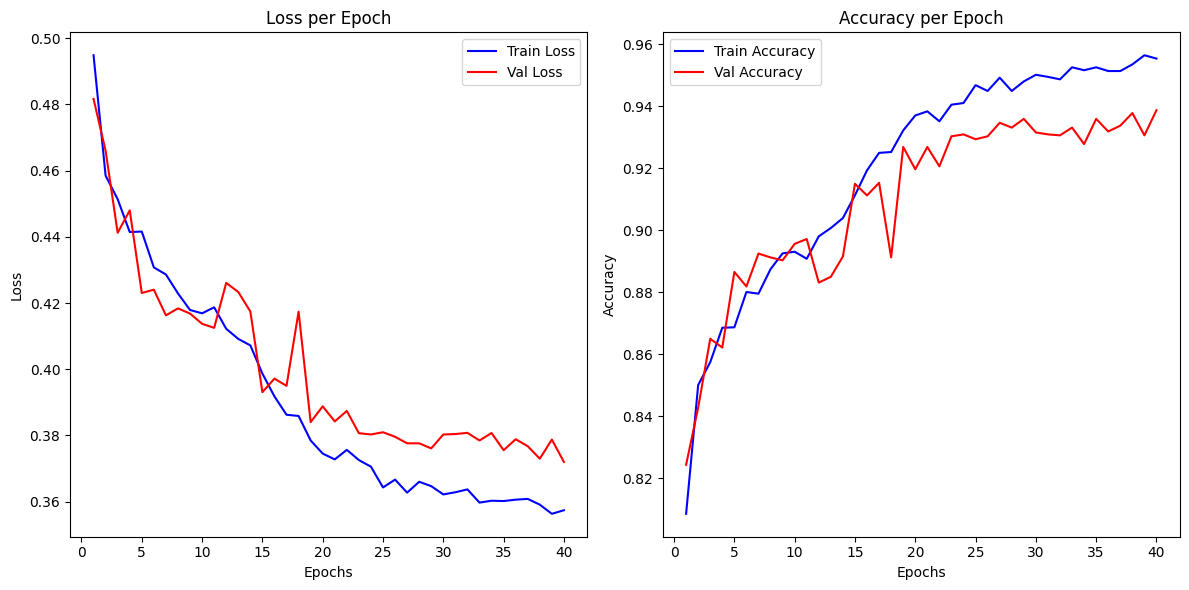

In [13]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=40, patience=10):
    best_acc = 0.0
    early_stop_counter = 0

    # Store metrics for plotting
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train Phase
        model.train()
        train_loss, train_corrects = 0.0, 0

        for inputs, labels in tqdm(dataloaders['train']):
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(torch.argmax(outputs, dim=1) == labels)

        train_loss /= len(dataloaders['train'].dataset)
        train_acc = train_corrects.double() / len(dataloaders['train'].dataset)

        # Validation Phase
        model.eval()
        val_loss, val_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(dataloaders['val']):
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(torch.argmax(outputs, dim=1) == labels)

        val_loss /= len(dataloaders['val'].dataset)
        val_acc = val_corrects.double() / len(dataloaders['val'].dataset)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Store metrics for visualization
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc.item())
        val_accuracies.append(val_acc.item())

        # Check early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            early_stop_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save best model
        else:
            early_stop_counter += 1

        # Adjust learning rate
        scheduler.step(val_loss)

        # Stop if no improvement
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    print(f"Best Validation Accuracy: {best_acc:.4f}")

    # Plot training and validation loss/accuracy
    plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plot training/validation loss and accuracy for each epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    # Plot Losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Val Loss', color='red')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Val Accuracy', color='red')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show plots
    plt.tight_layout()
    plt.show()

# Load dataset into train/val split
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=40, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=40, shuffle=False)
}

# Train the model
train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=40, patience=10)

Confusion Matrix:
 [[2108   65]
 [ 135  891]]
Classification Report:
               precision    recall  f1-score   support

         ALL       0.94      0.97      0.95      2173
         HEM       0.93      0.87      0.90      1026

    accuracy                           0.94      3199
   macro avg       0.94      0.92      0.93      3199
weighted avg       0.94      0.94      0.94      3199



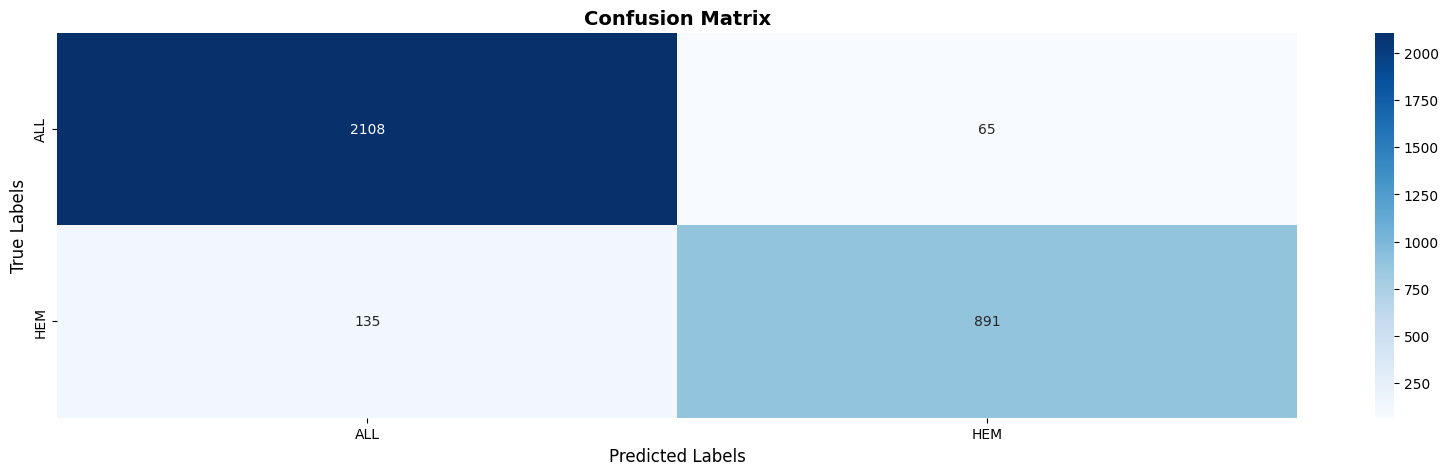

<Figure size 2000x500 with 0 Axes>

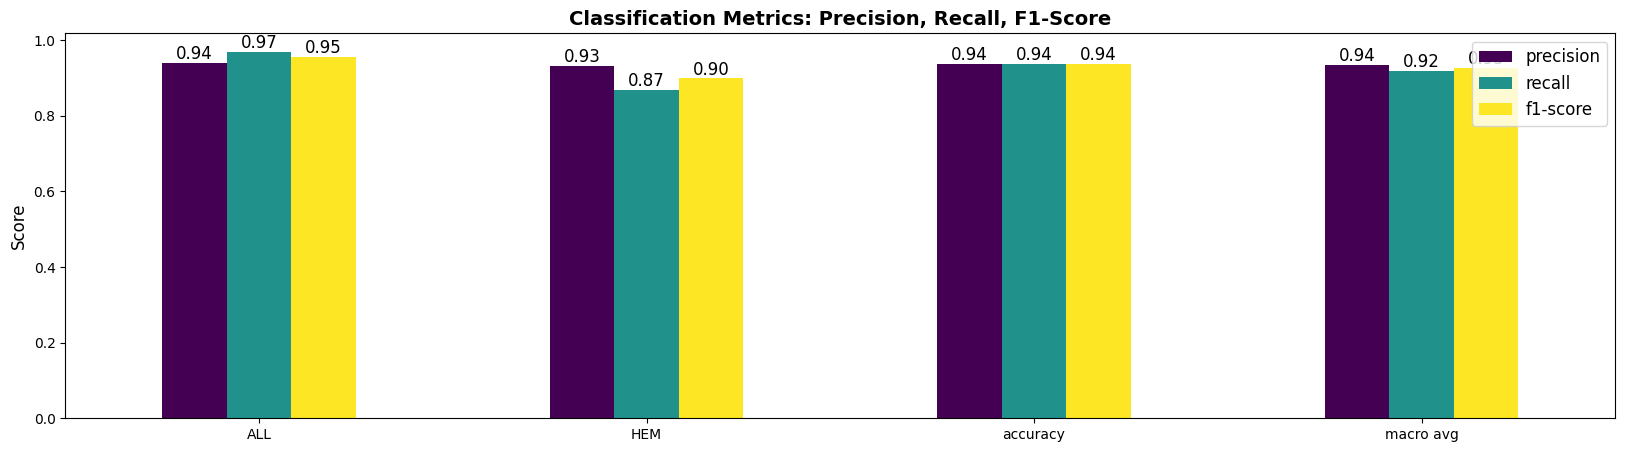

In [14]:
def evaluate_model(model, dataloader):
    model.load_state_dict(torch.load('best_model.pth'))  # Load best model
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute evaluation metrics
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['ALL', 'HEM'], output_dict=True)

    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['ALL', 'HEM']))

    # Confusion Matrix Visualization
    plt.figure(figsize=(20, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['ALL', 'HEM'], yticklabels=['ALL', 'HEM'])
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.show()

    # Classification Report: Precision, Recall, F1
    report_df = pd.DataFrame(report).transpose()
    metrics = report_df[['precision', 'recall', 'f1-score']].iloc[:-1]  # Remove 'accuracy' row

    plt.figure(figsize=(20, 5))
    ax = metrics.plot(kind='bar', figsize=(20, 5), colormap='viridis')

    # Add values on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=12)

    plt.title('Classification Metrics: Precision, Recall, F1-Score', fontsize=14, fontweight='bold')
    plt.ylabel('Score', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(loc='upper right', fontsize=12)
    plt.show()

# Evaluate on validation set
evaluate_model(model, dataloaders['val'])